In [1]:
import pandas as pd
import warnings

warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE, RandomOverSampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [12]:
df = pd.read_csv('input/mbti_data_clean.csv')

In [13]:
# Build the vocabulary from 1500 words that are not common words or MBTI personalities
vectorizer = CountVectorizer(stop_words = ['and','the','to','of','infj','entp','intp','intj','entj','enfj','infp','enfp','isfp','istp','isfj','istj','estp','esfp','estj','esfj','infjs','entps','intps','intjs','entjs','enfjs','infps','enfps','isfps','istps','isfjs','istjs','estps','esfps','estjs','esfjs'], max_features=1500, analyzer='word', max_df=0.8, min_df=0.1)

corpus = df['clean_posts'].values.reshape(1,-1).tolist()[0]

vectorizer.fit(corpus)

X_cnt = vectorizer.fit_transform(corpus)

# Transform the count matrix to a tf-idf representation
tfizer = TfidfTransformer()
tfizer.fit(X_cnt)

X = tfizer.fit_transform(X_cnt).toarray()

all_words = vectorizer.get_feature_names()

n_words = len(all_words)

X_df = pd.DataFrame.from_dict({w: X[:, i] for i, w in enumerate(all_words)})

In [14]:
def ei_tuned_model():
    y_df = df['E_I']

    oversampler = RandomOverSampler(sampling_strategy=0.9, random_state=0)
    
    X_cl, y_cl = oversampler.fit_resample(X_df, y_df)

    X_train, X_test, y_train, y_test = train_test_split(X_cl, y_cl, test_size=0.2, random_state=42, stratify=y_cl)
    
    model_classifier = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=None, min_samples_split=2)

    model = model_classifier.fit(X_train, y_train)

    return model

In [15]:
def sn_tuned_model():
    y_df = df['S_N']

    oversampler = RandomOverSampler(sampling_strategy=0.9, random_state=0)
    
    X_cl, y_cl = oversampler.fit_resample(X_df, y_df)

    X_train, X_test, y_train, y_test = train_test_split(X_cl, y_cl, test_size=0.2, random_state=42, stratify=y_cl)
    
    model_classifier = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None, min_samples_split=2)

    model = model_classifier.fit(X_train, y_train)

    return model

In [16]:
def tf_tuned_model():
    y_df = df['T_F']

    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42, stratify=y_df)
    
    model_classifier = SVC(probability=True, random_state=42, C=1, gamma='scale', kernel='rbf')

    model = model_classifier.fit(X_train, y_train)

    return model

In [17]:
def jp_tuned_model():
    y_df = df['J_P']

    oversampler = SMOTE(random_state=0)
    
    X_cl, y_cl = oversampler.fit_resample(X_df, y_df)

    X_train, X_test, y_train, y_test = train_test_split(X_cl, y_cl, test_size=0.2, random_state=42, stratify=y_cl)

    model_classifier = VotingClassifier(estimators=[
        ('SVM', SVC(probability=True, random_state=42, C=10, gamma='scale', kernel='rbf')),
        ('RandomForest', RandomForestClassifier(random_state=42, n_estimators=100, max_depth=20, min_samples_split=5)),
        ('LogisticRegression', LogisticRegression(random_state=42, C=1, solver='lbfgs')),
        ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, learning_rate=0.05, max_depth=10, n_estimators=300)),
    ], voting='soft')

    model = model_classifier.fit(X_train, y_train)

    return model

In [18]:
ei_model = ei_tuned_model()
sn_model = sn_tuned_model()
tf_model = tf_tuned_model()
jp_model = jp_tuned_model()

In [26]:
def mbti_class(model, text):
  final_test = tfizer.transform(vectorizer.transform([text.lower()])).toarray()

  test_point = pd.DataFrame.from_dict({w: final_test[:, i] for i, w in enumerate(all_words)})

  test_result = model.predict_proba(test_point)

  return test_result

In [44]:
#################################
# Apply models on single ticket #
#################################

ticket_infj = "To Whom It May Concern, I am writing today to complain of the poor service I received from your company on June 12, 2023. I was visited by a representative of That Awful Company, Mr. Madman, at my home on that day. I trust this is not the way That Awful Company wishes to conduct business with valued customers—I have been with you since the company was founded and have never encountered such treatment before. I would welcome the opportunity to discuss matters further and to learn of how you propose to prevent a similar situation from recurring. I look forward to hearing from you. Yours faithfully, Customer"

ticket_intp = "Dear [Company Name] Team, I’m writing to address some concerns regarding the service I received during a visit from your representative, Mr. Madman, on June 12, 2023. The interaction did not reflect the level of professionalism I’ve come to expect from [Company Name] throughout the many years I’ve been a customer. Specifically, I felt that the approach taken lacked the attentiveness and respect that are so vital to customer service. Given the positive experiences I’ve consistently had with your company, I was quite taken aback by this incident. I’d appreciate the chance to discuss this situation further and understand any steps you’re planning to ensure that future interactions better align with the service standards I value. Thank you for considering my feedback, and I look forward to your response. Best regards, Customer"

helpdesk_topic = ticket_intp

In [45]:
# E_I classifier test
ei_class_res = mbti_class(ei_model, helpdesk_topic)
ei_class_str = 'E' if (ei_class_res[0][0] < ei_class_res[0][1]) else 'I'

print(ei_class_res)
print(ei_class_str)

# S_N classifier test
sn_class_res = mbti_class(sn_model, helpdesk_topic)
sn_class_str = 'S' if (sn_class_res[0][0] < sn_class_res[0][1]) else 'N'

print(sn_class_res)
print(sn_class_str)

# classifier test
tf_class_res = mbti_class(tf_model, helpdesk_topic)
tf_class_str = 'T' if (tf_class_res[0][0] < tf_class_res[0][1]) else 'F'

print(tf_class_res)
print(tf_class_str)

# classifier test
jp_class_res = mbti_class(jp_model, helpdesk_topic)
jp_class_str = 'J' if (jp_class_res[0][0] < jp_class_res[0][1]) else 'P'

print(jp_class_res)
print(jp_class_str)

[[0.738 0.262]]
I
[[0.68 0.32]]
N
[[0.30982676 0.69017324]]
T
[[0.55602188 0.44397812]]
P


In [40]:
#####################################
# Apply model on real tickets #######
#####################################

df_tickets = pd.read_csv('input/kaggle_servicedesk_tickets_clean.csv', sep=',', decimal=',')

mbti_classifications = []

for i in range(len(df_tickets)):
    t =  df_tickets.iloc[i]['text']

    ei = mbti_class(ei_model, t)
    ei_str = 'E' if (ei[0][0] < ei[0][1]) else 'I'

    sn = mbti_class(sn_model, t)
    sn_str = 'S' if sn[0][0] < sn[0][1] else 'N'

    tf = mbti_class(tf_model, t)
    tf_str = 'T' if tf[0][0] < tf[0][1] else 'F'

    jp = mbti_class(jp_model, t)
    jp_str = 'J' if jp[0][0] < jp[0][1] else 'P'

    mbti_classifications.append(ei_str + sn_str + tf_str + jp_str)

df_tickets['mbti'] = mbti_classifications

df_tickets['e_i'] = df_tickets['mbti'].apply(lambda x: 1 if x[0] == 'E' else 0)
df_tickets['s_n'] = df_tickets['mbti'].apply(lambda x: 1 if x[1] == 'S' else 0)
df_tickets['t_f'] = df_tickets['mbti'].apply(lambda x: 1 if x[2] == 'T' else 0)
df_tickets['j_p'] = df_tickets['mbti'].apply(lambda x: 1 if x[3] == 'J' else 0)

clasified_tickets = df_tickets[['text', 'e_i', 's_n', 't_f', 'j_p', 'mbti']]

clasified_tickets.to_csv('output/kaggle_servicedesk_tickets_clean_classified.csv', index=False)

clasified_tickets.head(30)

,text,e_i,s_n,t_f,j_p,mbti
0,connection with icon icon dear please setup ic...,0,0,0,1,INFJ
1,work experience user work experience user hi w...,0,0,0,0,INFP
2,requesting for meeting requesting meeting hi p...,0,0,0,0,INFP
3,reset passwords for external accounts re expir...,0,0,1,1,INTJ
4,mail verification warning hi has got attached ...,0,0,0,0,INFP
5,mail please dear looks blacklisted receiving m...,0,0,0,1,INFJ
6,prod servers tunneling prod tunneling va la tu...,0,0,1,0,INTP
7,access request dear modules report report cost...,0,0,0,1,INFJ
8,reset passwords for our client and passwords c...,0,0,0,1,INFJ
9,direct reports missing time please action repo...,0,0,1,1,INTJ


In [41]:
cnt_srs = clasified_tickets['mbti'].value_counts()

cnt_srs

INTP    19695
INFP    13276
INFJ     7174
INTJ     7168
ISTP      264
ISFP      119
ISFJ       71
ISTJ       66
ENTP        4
Name: mbti, dtype: int64

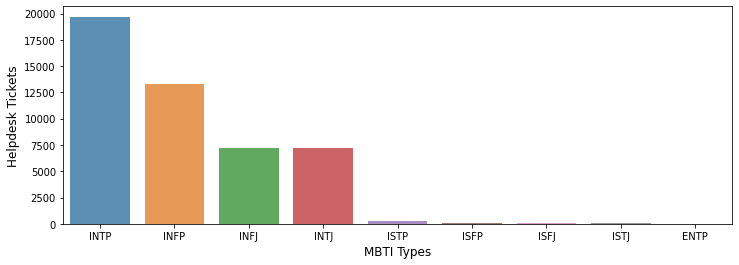

In [46]:
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Helpdesk Tickets', fontsize=12)
plt.xlabel('MBTI Types', fontsize=12)
plt.show()